# Loading HDB resale price data and performing analysis

In [666]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import scrap
import numpy as np
import csv
from pathlib import Path
import time
import re
import matplotlib.pyplot as plt
import geopandas
import contextily as ctx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1. Load files downloaded from [gov.sg](https://data.gov.sg/dataset/resale-flat-prices). Alternatively, use the api provided on the website to download the data.
1. Process the HDB data to add postal code, longitude and latitude information.
    1. To obtain postal code, use `block`, `street_name` and `town` information to pull the postal code from sites like google.com, google map api, streetdirectory.com or onemap.sg. These sites provide convenient apis for large scale queries.
    1. Since there are roughly 10000 unique HDB blocks compared to 800000+ transactions, it makes more sense to query every unique block than transaction. 
1. Pandas loads postal codes stored in .csv files as floats instead of strings. Converting postal codes back to strings is made harder by the presence of NaN.

`hdbdata` includes data that stretches back to 1990 and may include old buildings that no longer exists. In such cases, the postal codes are `NaN`.


In [668]:
# HDB Data
filename = []
filename.append('./data/raw/'+'resale-flat-prices-based-on-approval-date-1990-1999.csv')
filename.append('./data/raw/'+'resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
filename.append('./data/raw/'+'resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')
filename.append('./data/raw/'+'resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
filename.append('./data/raw/'+'resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')
data = []
for f in filename:
    data.append(pd.read_csv(f))

hdbdata = pd.concat(data,0, ignore_index=True, sort=True)
address_dictkey = list(hdbdata.groupby(['block','street_name','town']).groups.keys())

# Previously processed HDB data
hdbdata_processed = pd.read_csv('./data/processed/HDB_202005.csv',sep='\t').drop(columns='Unnamed: 0')
hdbdata_processed.loc[~hdbdata_processed['pc'].isna(),'pc'] = hdbdata_processed.loc[~hdbdata_processed['pc'].isna(),'pc'].apply(lambda x:'{0:06d}'.format(int(x)))

hdbdata_processed

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,town,pc,x,y
0,309,IMPROVED,1 ROOM,31.0,1977,1990-01,NaN,9000.0,10 TO 12,ANG MO KIO AVE 1,ANG MO KIO,562309,103.845142,1.364982
1,309,IMPROVED,1 ROOM,31.0,1977,1990-01,NaN,6000.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO,562309,103.845142,1.364982
2,309,IMPROVED,1 ROOM,31.0,1977,1990-01,NaN,8000.0,10 TO 12,ANG MO KIO AVE 1,ANG MO KIO,562309,103.845142,1.364982
3,309,IMPROVED,1 ROOM,31.0,1977,1990-01,NaN,6000.0,07 TO 09,ANG MO KIO AVE 1,ANG MO KIO,562309,103.845142,1.364982
4,216,NEW GENERATION,3 ROOM,73.0,1976,1990-01,NaN,47200.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO,560216,103.841350,1.366241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816305,364,Maisonette,EXECUTIVE,146.0,1988,2020-03,67.083333,540000.0,01 TO 03,YISHUN RING RD,YISHUN,760364,103.844603,1.429241
816306,359,Maisonette,EXECUTIVE,146.0,1988,2020-03,67.333333,578888.0,10 TO 12,YISHUN RING RD,YISHUN,760359,103.845862,1.427354
816307,292,Apartment,EXECUTIVE,165.0,1992,2020-03,71.250000,660000.0,01 TO 03,YISHUN ST 22,YISHUN,760292,103.837248,1.437039
816308,611,Maisonette,EXECUTIVE,146.0,1987,2020-03,66.666667,620000.0,04 TO 06,YISHUN ST 61,YISHUN,760611,103.835987,1.420223


1. geocode is a database that links all valid postal codes to their respective address and coordinates. It is obtained using streetdirectory.com's query api.
1. addr2pc is a database that links `block`, `street_name` and `town` information to postal codes and coordinates.

In [670]:
# Postal Code to Address
geocode = pd.read_csv('./data/raw/sggeocode.csv').rename(columns={"Unnamed: 0":"postalcode"})
geocode['postalcode'] = geocode['postalcode'].apply(lambda x:'{0:06d}'.format(x))
geocode = geocode.set_index('postalcode')

# HDB to Postal Code and coordinate
addr2pc = pd.read_csv('data/processed/unique_add2pc.csv',sep='\t').drop(columns='Unnamed: 0')
addr2pc['addr'] = addr2pc['addr'].apply(eval)
addr2pc.loc[~addr2pc['pc'].isna(),'pc'] = addr2pc.loc[~addr2pc['pc'].isna(),'pc'].apply(lambda x:'{0:06d}'.format(int(x)))
#pc2xy = geocode.reindex(list(addr2pc['pc']))[['x','y']]
#addr2pc['x'] = pc2xy.reset_index()['x']
#addr2pc['y'] = pc2xy.reset_index()['y']
addr2pc

,addr,pc,x,y
0,"(1, BEACH RD, KALLANG/WHAMPOA)",190001,103.864241,1.303753
1,"(1, BEDOK STH AVE 1, BEDOK)",460001,103.933776,1.320869
2,"(1, CHAI CHEE RD, BEDOK)",461001,103.922300,1.328047
3,"(1, CHANGI VILLAGE RD, PASIR RIS)",500001,103.987668,1.388374
4,"(1, DELTA AVE, BUKIT MERAH)",160001,103.828550,1.292093
...,...,...,...,...
9187,"(99A, LOR 2 TOA PAYOH, TOA PAYOH)",310099,103.846944,1.338848
9188,"(99B, LOR 2 TOA PAYOH, TOA PAYOH)",311099,103.847200,1.338704
9189,"(99C, LOR 2 TOA PAYOH, TOA PAYOH)",312099,103.847628,1.339234
9190,"(9A, BOON TIONG RD, BUKIT MERAH)",162009,103.828610,1.286967


The raw data shows the remaining lease as `x years y months`. To make comparison easier, convert remaining lease to years. Months are converted to decimals.

In [671]:
def convert_lease(x):
    if isinstance(x,str):
        years = int(re.search('^([0-9]{1,3})',x).group(1))
        if re.search('month',x):
            months = int(re.search('([0-9]{1,3}) month',x).group(1))
        else:
            # catch monthly
            months = 0
        return years+(months/12.)
    else:
        return x

hdbdata_processed['remaining_lease'] = hdbdata_processed['remaining_lease'].apply(convert_lease)

# Illustrating recent sale count as a choropleth
We can illustrate the data with a choropleth to visualize the number of recent sales in different areas of Singapore.  Pandas provides an easy way to select data from a range of datetime using conditionals. The data can then be grouped to the areas determined by sector code (first 2 digits of the postal code) using the `groupby()` method. 

In [672]:
hdbdata_recent = hdbdata_processed[hdbdata_processed['month'] > '2019-01']
hdb_rec_group = hdbdata_recent.groupby(hdbdata_recent['pc'].apply(lambda x:int(x[0:2])))
pc_count = hdb_rec_group['resale_price'].count()
pc_count.name='sale_counts'

To plot a choropleth, we use Geopandas, a geospatial software that is an extension of pandas. Geopandas accepts most spatial filetypes as input to generate a basic mapping which we can attach relevant data to. In this case, I generated a polygon shapefile using QGIS based on the sector code. Look out a future tutorial on how to generate shapefiles using QGIS!

Next, add the total sale counts from each sector to their respective polygon features. Since geopandas functions similarly to pandas, we can use functions like pd.concat to concatenate the data. Once added, plot the shapefile with the simple `.plot()` command. To add a baselayer to the choropleth, install `contextily`. The package automatically pulls rasterized images from openstreetmap.


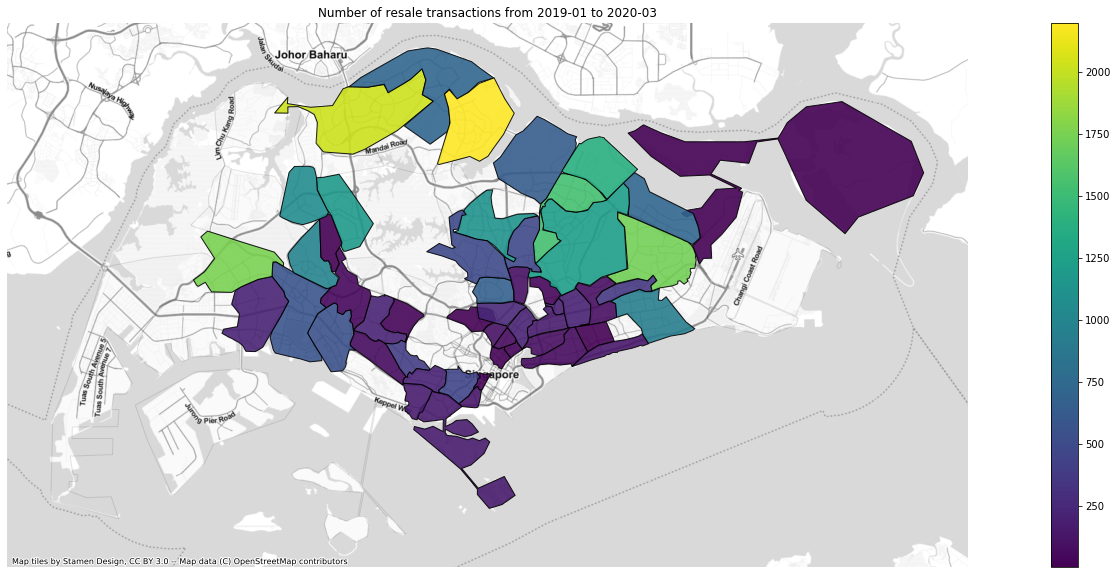

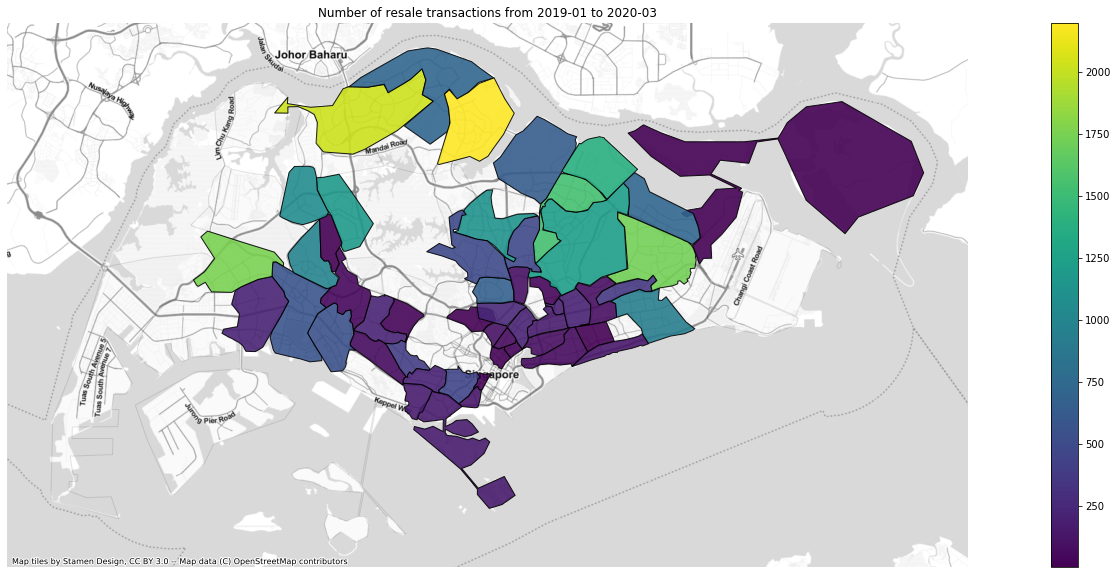

In [675]:
shapefile = Path('/home/jovyan/shared-notebooks/notebooks/HDB_analysis/data/processed/sectorcode/sectorcode.shp')
sgshp = geopandas.read_file(shapefile)
sgshp_3857 = sgshp.to_crs(epsg=3857)
sale_counts_shp = pd.concat([sgshp_3857.set_index('sectorcode'),pc_count],axis=1)

plt.close('all')
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot()
sale_counts_shp.plot(ax=ax,
                     column='sale_counts',
                     alpha=0.9,
                     edgecolor='k',
                     missing_kwds={'color': 'lightgrey', 'alpha':0.1},
                     legend=True,
                     )
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
ax.set_title('Number of resale transactions from 2019-01 to 2020-03')
fig

Recent sales are generally concentrated in areas with many apartments that reached MOP. 